<a href="https://colab.research.google.com/github/statscol/icesi_faii_final/blob/master/fundamentos_analiticaII_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller Fundamentos de Analítica 2

## Jhon Parra - Jhon López

El dataset "TransaccionesBancarias.csv" contiene la historia transaccional de diferentes clientes a los que se les otorgó un crédito bancario. Se trata de las agregaciones de las operaciones diarias de los 3 meses (90 días) previos a la demanda del crédito. Tenemos además la fecha del crédito, el monto prestado, y una indicación de si el cliente pudo cumplir con sus obligaciones de pago o no.


## **Carga de librerías necesarias**





In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
from plotnine import *



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Lectura de la información**

In [2]:
##READ FROM GITHUB REPO
!git clone https://github.com/statscol/icesi_faii_final
%ls

Cloning into 'icesi_faii_final'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.
icesi_faii_final/  sample_data/


In [22]:
datos=pd.read_csv("icesi_faii_final/TransaccionesBancarias.csv")
datos.head()

,ID,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7,dia_8,dia_9,dia_10,dia_11,dia_12,dia_13,dia_14,dia_15,dia_16,dia_17,dia_18,dia_19,dia_20,dia_21,dia_22,dia_23,dia_24,dia_25,dia_26,dia_27,dia_28,dia_29,dia_30,dia_31,dia_32,dia_33,dia_34,dia_35,dia_36,dia_37,dia_38,dia_39,...,dia_54,dia_55,dia_56,dia_57,dia_58,dia_59,dia_60,dia_61,dia_62,dia_63,dia_64,dia_65,dia_66,dia_67,dia_68,dia_69,dia_70,dia_71,dia_72,dia_73,dia_74,dia_75,dia_76,dia_77,dia_78,dia_79,dia_80,dia_81,dia_82,dia_83,dia_84,dia_85,dia_86,dia_87,dia_88,dia_89,dia_90,pago,fecha,monto
0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,-3500.00,...,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,-30.0,0.0,0.0,-102.00,0.0,0.0,0.00,0.00,0.0,-488.43,0.0,0.0,0.0,0.0,-20.0,-5743.11,NO,2019-04-16 10:55:50.111,150.0
1,2,20323.83,0.00,0.00,1149.58,-807.37,1240.97,1189.47,-11766.97,0.00,0.00,-277.23,1911.71,-3333.63,1351.12,-994.11,0.00,0.00,-2584.20,1490.1,1497.91,909.02,-2552.57,0.00,0.00,1369.02,-2527.99,1349.96,-2708.84,-948.15,0.00,0.00,1751.82,1523.25,2105.0,1785.60,526.27,0.00,0.00,299.15,...,1490.23,1470.19,1744.23,0.0,0.0,0.0,-270.07,1590.93,-7581.79,-3303.89,1256.7,0.0,0.0,1224.79,-1671.22,1303.49,-3220.97,1509.8,0.0,0.0,-1490.2,1509.8,0.0,0.0,-3034.03,0.0,0.0,1323.34,1323.34,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-04-16 16:15:32.991,100.0
2,3,0.00,0.00,-7.15,-7.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-150.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.0,0.0,-30.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-30.0,0.0,0.00,NO,2019-04-29 17:47:37.833,100.0
3,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-40.34,-138.75,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.0,0.0,-7.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-7.0,0.0,0.00,NO,2019-04-29 20:28:54.543,100.0
4,6,17.02,188.69,-62.19,288.53,0.00,0.00,-266.58,-6.97,103.49,-41.82,-831.44,0.00,0.00,288.96,87.07,63.04,-630.05,960.54,0.0,0.00,32.29,14.70,-365.65,-261.43,18.39,0.00,0.00,304.50,212.35,27.61,-310.73,524.48,0.00,0.0,-230.03,6.25,84.03,-115.45,395.57,...,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-05-03 14:46:39.028,900.0


## Limpieza y Transformación de la Información

In [0]:
datos=datos.set_index(['ID'])

In [0]:
#cambiar a tipo fecha
datos['fecha']=pd.to_datetime(datos.fecha) 

###creacion de variables 
datos['TotalMovMes1']=datos.iloc[:,1:31].sum(axis=1)
datos['TotalMovMes2']=datos.iloc[:,31:61].sum(axis=1)
datos['TotalMovMes3']=datos.iloc[:,61:91].sum(axis=1)

def dicotomizacion(x):
  if x>0:
    return(1)
  elif(x<0):
    return(-1)
  else:
    return(0)


VarsMovs=pd.DataFrame(datos.iloc[:,0:90].apply(lambda x:[dicotomizacion(a) for a in x],axis=0))
VarsMovs.columns=['Dico'+'_' + s1 for s1 in VarsMovs.columns]
VarsMovs.head()


VarsMovs['Mes1_NoMov']=(VarsMovs.iloc[:,0:30]==0).astype(int).sum(axis=1)
VarsMovs['Mes1_MovInt']=(VarsMovs.iloc[:,0:30]==1).astype(int).sum(axis=1)
VarsMovs['Mes1_MovOut']=(VarsMovs.iloc[:,0:30]==-1).astype(int).sum(axis=1)

VarsMovs['Mes2_NoMov']=(VarsMovs.iloc[:,30:60]==0).astype(int).sum(axis=1)
VarsMovs['Mes2_MovInt']=(VarsMovs.iloc[:,30:60]==1).astype(int).sum(axis=1)
VarsMovs['Mes2_MovOut']=(VarsMovs.iloc[:,30:60]==-1).astype(int).sum(axis=1)

VarsMovs['Mes3_NoMov']=(VarsMovs.iloc[:,60:90]==0).astype(int).sum(axis=1)
VarsMovs['Mes3_MovInt']=(VarsMovs.iloc[:,60:90]==1).astype(int).sum(axis=1)
VarsMovs['Mes3_MovOut']=(VarsMovs.iloc[:,60:90]==-1).astype(int).sum(axis=1)




In [8]:
VarsMovs=VarsMovs.reset_index()
datos=datos.reset_index()

VarsFinal=VarsMovs.loc[:,['ID','Mes1_NoMov','Mes1_MovInt','Mes1_MovOut',
                'Mes2_NoMov','Mes2_MovInt','Mes2_MovOut',
                'Mes3_NoMov','Mes3_MovInt','Mes3_MovOut']]

VarsFinal

,ID,Mes1_NoMov,Mes1_MovInt,Mes1_MovOut,Mes2_NoMov,Mes2_MovInt,Mes2_MovOut,Mes3_NoMov,Mes3_MovInt,Mes3_MovOut
0,1,29,0,1,28,0,2,25,0,5
1,2,9,11,10,10,15,5,16,8,6
2,3,27,0,3,27,0,3,29,0,1
3,5,28,0,2,28,0,2,29,0,1
4,6,8,14,8,20,6,4,30,0,0
...,...,...,...,...,...,...,...,...,...,...
1373,1481,29,0,1,30,0,0,30,0,0
1374,1482,7,10,13,8,9,13,6,9,15
1375,1483,6,6,18,1,11,18,5,7,18
1376,1484,8,3,19,14,4,12,29,1,0


In [12]:
DatosFinal.head()

,index,ID,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7,dia_8,dia_9,dia_10,dia_11,dia_12,dia_13,dia_14,dia_15,dia_16,dia_17,dia_18,dia_19,dia_20,dia_21,dia_22,dia_23,dia_24,dia_25,dia_26,dia_27,dia_28,dia_29,dia_30,dia_31,dia_32,dia_33,dia_34,dia_35,dia_36,dia_37,dia_38,...,dia_66,dia_67,dia_68,dia_69,dia_70,dia_71,dia_72,dia_73,dia_74,dia_75,dia_76,dia_77,dia_78,dia_79,dia_80,dia_81,dia_82,dia_83,dia_84,dia_85,dia_86,dia_87,dia_88,dia_89,dia_90,pago,fecha,monto,TotalMovMes1,TotalMovMes2,TotalMovMes3,Mes1_NoMov,Mes1_MovInt,Mes1_MovOut,Mes2_NoMov,Mes2_MovInt,Mes2_MovOut,Mes3_NoMov,Mes3_MovInt,Mes3_MovOut
0,0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,-30.0,0.0,0.0,-102.00,0.0,0.0,0.00,0.00,0.0,-488.43,0.0,0.0,0.0,0.0,-20.0,-5743.11,NO,2019-04-16 10:55:50.111,150.0,-30.00,-3530.00,-6383.54,29,0,1,28,0,2,25,0,5
1,1,2,20323.83,0.00,0.00,1149.58,-807.37,1240.97,1189.47,-11766.97,0.00,0.00,-277.23,1911.71,-3333.63,1351.12,-994.11,0.00,0.00,-2584.20,1490.1,1497.91,909.02,-2552.57,0.00,0.00,1369.02,-2527.99,1349.96,-2708.84,-948.15,0.00,0.00,1751.82,1523.25,2105.0,1785.60,526.27,0.00,0.00,...,0.0,1224.79,-1671.22,1303.49,-3220.97,1509.8,0.0,0.0,-1490.2,1509.8,0.0,0.0,-3034.03,0.0,0.0,1323.34,1323.34,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-04-16 16:15:32.991,100.0,-15042.20,14736.95,-10850.84,9,11,10,10,15,5,16,8,6
2,2,3,0.00,0.00,-7.15,-7.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-150.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-30.0,0.0,0.00,NO,2019-04-29 17:47:37.833,100.0,-194.30,-3530.00,-30.00,27,0,3,27,0,3,29,0,1
3,3,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-40.34,-138.75,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-7.0,0.0,0.00,NO,2019-04-29 20:28:54.543,100.0,-186.09,-7.00,-7.00,28,0,2,28,0,2,29,0,1
4,4,6,17.02,188.69,-62.19,288.53,0.00,0.00,-266.58,-6.97,103.49,-41.82,-831.44,0.00,0.00,288.96,87.07,63.04,-630.05,960.54,0.0,0.00,32.29,14.70,-365.65,-261.43,18.39,0.00,0.00,304.50,212.35,27.61,-310.73,524.48,0.00,0.0,-230.03,6.25,84.03,-115.45,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-05-03 14:46:39.028,900.0,-186.70,752.36,0.00,8,14,8,20,6,4,30,0,0


In [0]:
DatosFinal=pd.merge(datos,VarsFinal,how='left',on='ID')

DatosFinal=DatosFinal.drop(['index'],axis=1)


In [14]:
#pago: cambiar a binaria. 1 si no pagó, 0 si pagó
DatosFinal['pago_m']=pd.get_dummies(DatosFinal.pago)["NO"]
DatosFinal.head()

,ID,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7,dia_8,dia_9,dia_10,dia_11,dia_12,dia_13,dia_14,dia_15,dia_16,dia_17,dia_18,dia_19,dia_20,dia_21,dia_22,dia_23,dia_24,dia_25,dia_26,dia_27,dia_28,dia_29,dia_30,dia_31,dia_32,dia_33,dia_34,dia_35,dia_36,dia_37,dia_38,dia_39,...,dia_67,dia_68,dia_69,dia_70,dia_71,dia_72,dia_73,dia_74,dia_75,dia_76,dia_77,dia_78,dia_79,dia_80,dia_81,dia_82,dia_83,dia_84,dia_85,dia_86,dia_87,dia_88,dia_89,dia_90,pago,fecha,monto,TotalMovMes1,TotalMovMes2,TotalMovMes3,Mes1_NoMov,Mes1_MovInt,Mes1_MovOut,Mes2_NoMov,Mes2_MovInt,Mes2_MovOut,Mes3_NoMov,Mes3_MovInt,Mes3_MovOut,pago_m
0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,-3500.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,-30.0,0.0,0.0,-102.00,0.0,0.0,0.00,0.00,0.0,-488.43,0.0,0.0,0.0,0.0,-20.0,-5743.11,NO,2019-04-16 10:55:50.111,150.0,-30.00,-3530.00,-6383.54,29,0,1,28,0,2,25,0,5,1
1,2,20323.83,0.00,0.00,1149.58,-807.37,1240.97,1189.47,-11766.97,0.00,0.00,-277.23,1911.71,-3333.63,1351.12,-994.11,0.00,0.00,-2584.20,1490.1,1497.91,909.02,-2552.57,0.00,0.00,1369.02,-2527.99,1349.96,-2708.84,-948.15,0.00,0.00,1751.82,1523.25,2105.0,1785.60,526.27,0.00,0.00,299.15,...,1224.79,-1671.22,1303.49,-3220.97,1509.8,0.0,0.0,-1490.2,1509.8,0.0,0.0,-3034.03,0.0,0.0,1323.34,1323.34,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-04-16 16:15:32.991,100.0,-15042.20,14736.95,-10850.84,9,11,10,10,15,5,16,8,6,1
2,3,0.00,0.00,-7.15,-7.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-150.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-30.0,0.0,0.00,NO,2019-04-29 17:47:37.833,100.0,-194.30,-3530.00,-30.00,27,0,3,27,0,3,29,0,1,1
3,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-40.34,-138.75,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-7.0,0.0,0.00,NO,2019-04-29 20:28:54.543,100.0,-186.09,-7.00,-7.00,28,0,2,28,0,2,29,0,1,1
4,6,17.02,188.69,-62.19,288.53,0.00,0.00,-266.58,-6.97,103.49,-41.82,-831.44,0.00,0.00,288.96,87.07,63.04,-630.05,960.54,0.0,0.00,32.29,14.70,-365.65,-261.43,18.39,0.00,0.00,304.50,212.35,27.61,-310.73,524.48,0.00,0.0,-230.03,6.25,84.03,-115.45,395.57,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-05-03 14:46:39.028,900.0,-186.70,752.36,0.00,8,14,8,20,6,4,30,0,0,1


## Análisis Exploratorio

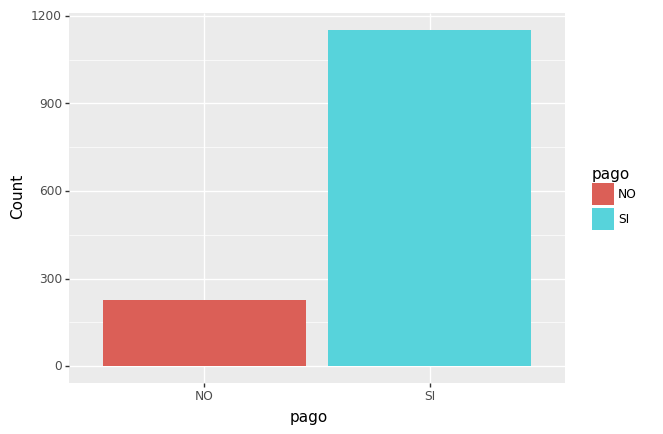

<ggplot: (8784728987319)>

In [0]:
Baseline=pd.DataFrame({'Count':DatosFinal.groupby(['pago']).size()})
Baseline=Baseline.reset_index()



ggplot(aes(x='TotalMovMes1',color='pago'),data=DatosFinal)+\
geom_density()

ggplot(aes(x='TotalMovMes2',color='pago'),data=DatosFinal)+\
geom_density()

ggplot(aes(x='TotalMovMes3',color='pago'),data=DatosFinal)+\
geom_density()



ggplot(aes(x='Mes1_NoMov',color='pago'),data=DatosFinal)+\
geom_density()

ggplot(aes(x='Mes2_NoMov',color='pago'),data=DatosFinal)+\
geom_density()

ggplot(aes(x='Mes3_NoMov',color='pago'),data=DatosFinal)+\
geom_density()



ggplot(aes(x='Mes1_MovInt',color='pago'),data=DatosFinal)+\
geom_density()

ggplot(aes(x='Mes2_MovInt',color='pago'),data=DatosFinal)+\
geom_density()

ggplot(aes(x='Mes3_MovInt',color='pago'),data=DatosFinal)+\
geom_density()



ggplot(aes(x='Mes1_MovOut',color='pago'),data=DatosFinal)+\
geom_density()

ggplot(aes(x='Mes2_MovOut',color='pago'),data=DatosFinal)+\
geom_density()

ggplot(aes(x='Mes3_MovOut',color='pago'),data=DatosFinal)+\
geom_density()


ggplot(aes(x='pago',y='Count',fill='pago'),data=Baseline)+\
geom_col()


### Habrá diferencias en el comportamiento de los créditos otorgados por mes o por día?

In [48]:
def highlight(val):
  return ['background-color: red' if a>0.7 else '' for a in val] 

#por hora de aprobación
ct=pd.crosstab(DatosFinal.fecha.dt.hour,DatosFinal.pago_m,normalize="index").transpose()
ct.style.apply(highlight)

fecha,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
pago_m,,,,,,,,,,,,,,,,,,,,,,,,
0,0.862069,0.859649,0.820513,0.782609,0.826087,0.805556,0.909091,0.736842,0.956522,0.833333,0.828571,0.812500,0.567901,0.855263,0.857143,0.895833,0.793478,0.902778,0.756410,0.898305,0.842857,0.895522,0.929412,0.826923
1,0.137931,0.140351,0.179487,0.217391,0.173913,0.194444,0.090909,0.263158,0.043478,0.166667,0.171429,0.187500,0.432099,0.144737,0.142857,0.104167,0.206522,0.097222,0.243590,0.101695,0.157143,0.104478,0.070588,0.173077


In [49]:
##por día del mes
ct=pd.crosstab(DatosFinal.fecha.dt.day,DatosFinal.pago_m,normalize="index").transpose()
ct.style.apply(highlight)

fecha,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
pago_m,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.791667,0.833333,0.904762,0.875000,0.918033,0.788889,0.800000,0.852941,0.863636,0.854839,0.844444,0.901639,0.887324,0.866667,0.750000,0.838710,0.941176,0.888889,0.506329,0.857143,0.818182,0.833333,0.807692,0.941176,0.823529,0.873016,0.847458,0.871795,0.744681,0.888889,0.894737
1,0.208333,0.166667,0.095238,0.125000,0.081967,0.211111,0.200000,0.147059,0.136364,0.145161,0.155556,0.098361,0.112676,0.133333,0.250000,0.161290,0.058824,0.111111,0.493671,0.142857,0.181818,0.166667,0.192308,0.058824,0.176471,0.126984,0.152542,0.128205,0.255319,0.111111,0.105263


In [50]:
#por mes de aprobación
#parece que las personas que obtuvieron prestamos de abril a mayo, o las que lo hicieorn en noviembre, no pagan sus obligaciones
ct=pd.crosstab(DatosFinal.fecha.dt.month,DatosFinal.pago_m,normalize="index").transpose()
ct.style.apply(highlight)

fecha,1,2,3,4,5,6,7,8,9,10,11,12
pago_m,,,,,,,,,,,,
0,0.407407,0.937500,1.000000,0.000000,0.000000,0.000000,0.840336,0.838843,0.918089,0.500000,0.316667,0.784615
1,0.592593,0.062500,0.000000,1.000000,1.000000,1.000000,0.159664,0.161157,0.081911,0.500000,0.683333,0.215385


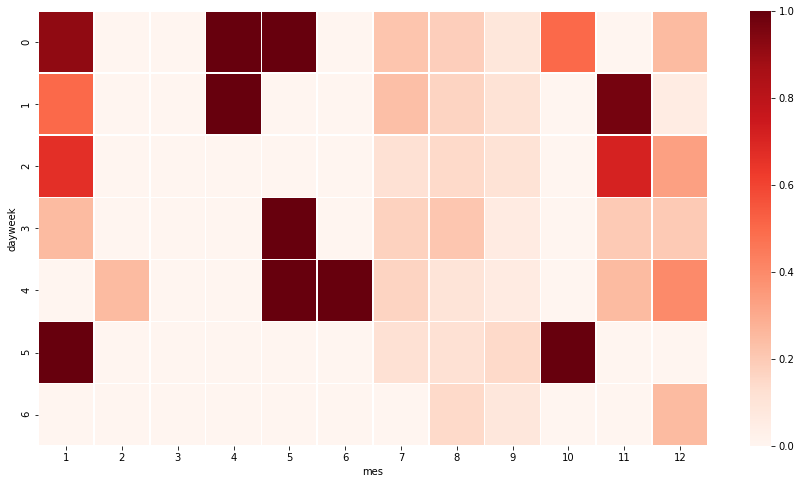

In [76]:
# vimos que existen meses en los que las personas no cumplieron con sus obligaciones. Sin embargo  veamos si este comportamiento
# puede desagregarse por día de la semana en que fue aprobado.
dataux=DatosFinal
dataux['mes']=DatosFinal.fecha.dt.month
dataux['dayweek']=DatosFinal.fecha.dt.dayofweek

ct=pd.pivot_table(dataux, values='pago_m', index=['mes'],
                    columns=['dayweek'], aggfunc=np.mean).fillna(0).transpose()
import matplotlib.pyplot as plt

ax,fig=plt.subplots(figsize=(15,8))
ax=sns.heatmap(ct,cmap='Reds',linewidths=.5)

In [75]:
pd.pivot_table(dataux, values='pago_m', index=['mes'],
                    columns=['dayweek'], aggfunc=np.mean).fillna(0)

dayweek,0,1,2,3,4,5,6
mes,,,,,,,
1,0.916667,0.500000,0.666667,0.250000,0.000000,1.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
7,0.217391,0.235294,0.117647,0.173913,0.166667,0.117647,0.000000
8,0.186275,0.166667,0.146667,0.211111,0.104478,0.117647,0.148148
9,0.089552,0.109589,0.111111,0.059524,0.059259,0.148148,0.085714


## Ajuste de Modelos 